In [1]:
import warnings
warnings.filterwarnings('ignore') #do not disturb mode

import numpy as np #vectors and matrices
import pandas as pd #tables and data manipulations

import matplotlib.pyplot as plt #plots
import seaborn as sns #plots

from dateutil.relativedelta import relativedelta #working with dates
from datetime import date,datetime

from scipy.optimize import minimize #function for minimization

import statsmodels.formula.api as smf #statistics and econometrics
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product #useful functions
from tqdm  import tqdm_notebook

import os

%matplotlib inline

In [2]:
PATH_TO_DATA = 'data/predict_future_sales'
sales_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'sales_train_v2.csv'))
items = pd.read_csv(os.path.join(PATH_TO_DATA, 'items.csv'))
item_categories = pd.read_csv(os.path.join(PATH_TO_DATA, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(PATH_TO_DATA, 'shops.csv'))
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'))

In [3]:
sales_train['date'] = sales_train['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))

In [4]:
#Item count day outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
#Item price outliers: [11365  6066 13199]
#lets remove item count day above 100000 and price above 1000
sales_train = sales_train[sales_train['item_price']<100001]
sales_train = sales_train[sales_train['item_cnt_day']<1001]

In [5]:
%%time
#based on the shop name removing the duplicate shops in the sales train and test data set

# !Якутск Орджоникидзе, 56 фран == Якутск Орджоникидзе, 56
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
# !Якутск ТЦ "Центральный" фран == Якутск ТЦ "Центральный"
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м? == Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

CPU times: user 2.05 s, sys: 99.9 ms, total: 2.15 s
Wall time: 544 ms


In [6]:
#Replacing negative price with mean
#sales_train.loc[sales_train.item_price<0]
mean_price = sales_train[(sales_train['shop_id']==32)&(sales_train['item_id']==2973)&(sales_train['date_block_num']==4)&(sales_train['item_price']>0)]['item_price'].mean()
sales_train.loc[sales_train['item_price']<0, 'item_price'] = mean_price

In [7]:
sales_train['year'] = sales_train['date'].apply(lambda x: x.year).astype(np.int16)
sales_train['month'] = sales_train['date'].apply(lambda x: x.month).astype(np.int16)

In [8]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [9]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
#removing !
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [10]:
#temp_df = pd.merge(sales_train, shops, on=['shop_id'], how='left')
#temp_df = pd.merge(temp_df, items, on=['item_id'], how='left')
#temp_df = pd.merge(temp_df, item_categories, on=['item_category_id'], how='left')
#temp_df.drop(['shop_name','item_name','item_category_name','split'], axis=1, inplace=True)

In [11]:
#temp_df.to_pickle('data/sales_train_tsa1.pkl')

In [15]:
#temp_df.head()

In [10]:
sales_train.drop('date', axis=1, inplace=True)

In [11]:
month_group = sales_train.groupby(['date_block_num','shop_id','item_id','year','month']).agg({'item_cnt_day': ['sum']})
month_group.columns = ['item_cnt_month']
month_group.reset_index(inplace=True)

In [12]:
month_group.head()

,date_block_num,shop_id,item_id,year,month,item_cnt_month
0,0,2,27,2013,1,1.0
1,0,2,33,2013,1,1.0
2,0,2,317,2013,1,1.0
3,0,2,438,2013,1,1.0
4,0,2,471,2013,1,2.0


In [13]:
test['date_block_num'] = 34
test['month'] = 11
test['year'] = 2015
test['item_cnt_month'] = 0

In [14]:
test.drop('ID', axis=1, inplace=True)

In [15]:
test.head()

,shop_id,item_id,date_block_num,month,year,item_cnt_month
0,5,5037,34,11,2015,0
1,5,5320,34,11,2015,0
2,5,5233,34,11,2015,0
3,5,5232,34,11,2015,0
4,5,5268,34,11,2015,0


In [16]:
cols = ['date_block_num','shop_id','item_id']
full_df = pd.concat([month_group, test], ignore_index=True, keys=cols)

In [18]:
full_df = pd.merge(full_df, shops, on=['shop_id'], how='left')
full_df = pd.merge(full_df, items, on=['item_id'], how='left')
full_df = pd.merge(full_df, item_categories, on=['item_category_id'], how='left')

In [19]:
full_df.drop(['shop_name','item_name','item_category_name','split'], axis=1, inplace=True)

In [20]:
full_df.head()

,date_block_num,item_cnt_month,item_id,month,shop_id,year,city,item_category_id,type,subtype
0,0,1.0,27,1,2,2013,Адыгея,19,Игры,PS3
1,0,1.0,33,1,2,2013,Адыгея,37,Кино,Blu
2,0,1.0,317,1,2,2013,Адыгея,45,Книги,Аудиокниги 1С
3,0,1.0,438,1,2,2013,Адыгея,45,Книги,Аудиокниги 1С
4,0,2.0,471,1,2,2013,Адыгея,49,Книги,Методические материалы 1С


In [21]:
full_df.to_pickle('data/full_df_tsa1.pkl')

In [26]:
sales_train_monthly = full_df.groupby(['date_block_num'])[['item_cnt_month']].sum()
sales_train_monthly.columns = ['item_cnt_month']
sales_train_monthly.reset_index(inplace=True)

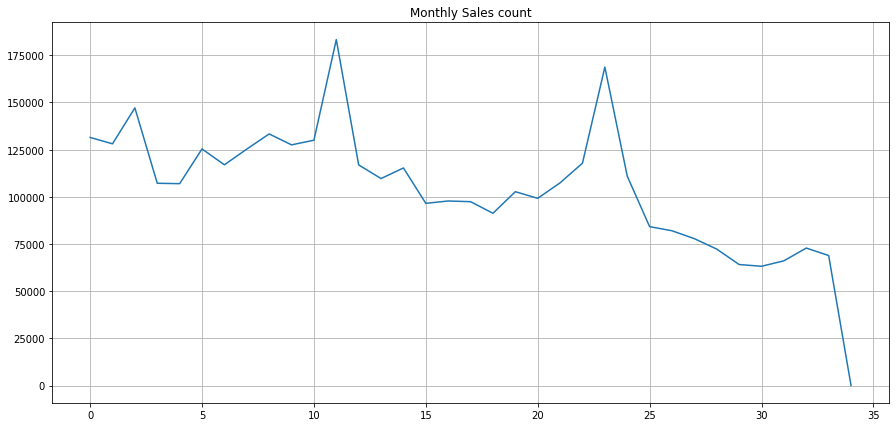

CPU times: user 223 ms, sys: 12 ms, total: 235 ms
Wall time: 233 ms


In [27]:
%%time
plt.figure(figsize=(15, 7))
plt.plot(sales_train_monthly['item_cnt_month'])
plt.title('Monthly Sales count')
plt.grid(True)
plt.show()

## Forecast quality metrics